In [1]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/named-entity-recognition-ner-corpus/ner.csv


In [2]:
import tensorflow
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.utils import plot_model
from numpy.random import seed
seed(1)
tensorflow.random.set_seed(2)

In [3]:
data=pd.read_csv("/kaggle/input/named-entity-recognition-ner-corpus/ner.csv",encoding= 'unicode_escape')
data.head(5)

,Sentence #,Sentence,POS,Tag
0,Sentence: 1,Thousands of demonstrators have marched throug...,"['NNS', 'IN', 'NNS', 'VBP', 'VBN', 'IN', 'NNP'...","['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', '..."
1,Sentence: 2,Families of soldiers killed in the conflict jo...,"['NNS', 'IN', 'NNS', 'VBN', 'IN', 'DT', 'NN', ...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
2,Sentence: 3,They marched from the Houses of Parliament to ...,"['PRP', 'VBD', 'IN', 'DT', 'NNS', 'IN', 'NN', ...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
3,Sentence: 4,"Police put the number of marchers at 10,000 wh...","['NNS', 'VBD', 'DT', 'NN', 'IN', 'NNS', 'IN', ...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
4,Sentence: 5,The protest comes on the eve of the annual con...,"['DT', 'NN', 'VBZ', 'IN', 'DT', 'NN', 'IN', 'D...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."


In [4]:
from itertools import chain
def make_dict_map(data, tokentag):
    token_to_idx = {}
    idx_to_token = {}  
    if tokentag == 'token':
        voc = list(set(data['Sentence'].to_list()))
    else:
        voc = list(set(data['Tag'].to_list()))
    idx_to_token = {idx:tok for  idx, tok in enumerate(voc)}
    token_to_idx = {tok:idx for  idx, tok in enumerate(voc)}
    return token_to_idx , idx_to_token

In [5]:
token_to_idx, idx_to_token = make_dict_map(data, 'token')
tag_to_idx, idx_to_tag = make_dict_map(data, 'tag')
data['Word_idx'] = data['Sentence'].map(token_to_idx)
data['Tag_idx'] = data['Tag'].map(tag_to_idx)
data_fillna = data.fillna(method='ffill', axis=0)
data_group = data_fillna.groupby(['Sentence #'],as_index=False)['Sentence', 'POS', 'Tag', 'Word_idx', 'Tag_idx'].agg(lambda x: list(x))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [6]:
def get_train_test_val(data_group, datas):
    tokens = data_group['Word_idx'].tolist()
    maxlen = max([len(s) for s in tokens])
    ntoken = len(list(set(datas['Word'].to_list())))
    ntag = len(list(set(datas['Tag'].to_list())))    
    padtokens = pad_sequences(tokens, maxlen=maxlen, dtype='int32', padding='post', value= ntoken - 1)
    tags = data_group['Tag_idx'].tolist()
    padtags = pad_sequences(tags, maxlen=maxlen, dtype='int32', padding='post', value= tag_to_idx["O"])
    ntags = len(tag_to_idx)
    padtags = [to_categorical(i, num_classes=ntags) for i in padtags]
    tokens, testtokens, tags, testtags = train_test_split(padtokens, padtags, test_size=0.1, train_size=0.9, random_state=2020)
    traintokens, valtokens, traintags, valtags = train_test_split(tokens,tags,test_size = 0.25,train_size =0.75, random_state=2020)
    print(
        'length of train tokens :', len(train_tokens),
        '\nlength of train tags   :', len(train_tags),
        '\nlength of test tokens  :', len(test_tokens),
        '\nlength of test tags    :', len(test_tags),
        '\nlength of val tokens   :', len(val_tokens),
        '\nlength of val tags     :', len(val_tags),
    )
    
    return traintokens, testtokens, valtokens, traintags,testtags,valtags

In [7]:
input_dim = len(list(set(data['Sentence'].to_list())))+1
output_dim = 64
input_length = max([len(s) for s in data_group['Word_idx'].tolist()])
ntags = len(tag_to_idx)
ntags
def get_bilstmlstm():
    model = Sequential()
    model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length))
    model.add(Bidirectional(LSTM(units=output_dim, return_sequences=True, dropout=0.2, recurrent_dropout=0.2), merge_mode = 'concat'))
    model.add(LSTM(units=output_dim, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))
    model.add(TimeDistributed(Dense(1, activation="relu")))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [8]:
def train_model(X, y, model):
    loss = list()
    for i in range(25):
        hist = model.fit(X, y, batch_size=1000, verbose=1, epochs=1, validation_split=0.2)
        loss.append(hist.history['loss'][0])
    return loss

2022-08-03 13:58:01.644709: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1, 64)             3044864   
_________________________________________________________________
bidirectional (Bidirectional (None, 1, 128)            66048     
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 64)             49408     
_________________________________________________________________
time_distributed (TimeDistri (None, 1, 1)              65        
Total params: 3,160,385
Trainable params: 3,160,385
Non-trainable params: 0
_________________________________________________________________


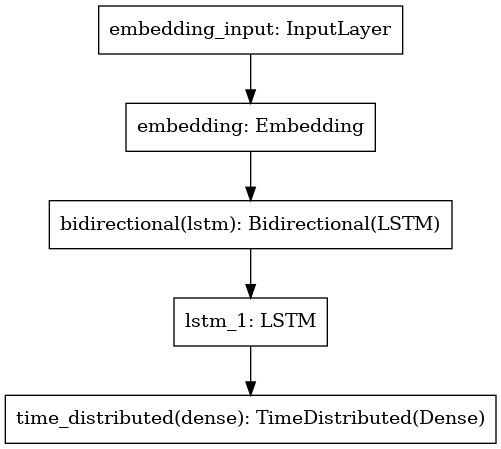

In [9]:
results = pd.DataFrame()
model_bilstm_lstm = get_bilstmlstm()
plot_model(model_bilstm_lstm)